In [56]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import time
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import splitfolders
splitfolders.ratio('datasets\Grapevine_Leaves_Image_Dataset', output='data', ratio = (0.7, 0.2, 0.1))

In [51]:
# setting the size to this
IMAGE_SIZE = (224, 224)

train_path = './data/train'
val_path = './data/val'
test_path = './data/test'

train_datagen = ImageDataGenerator(rescale = 1./255)

eval_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_batch = train_datagen.flow_from_directory('./data/train',
                                                 target_size = (224, 224), # should be same as the initialized one
                                                 batch_size = 10, class_mode = 'categorical')

val_batch = eval_datagen.flow_from_directory('./data/val',
                                                 target_size = (224, 224),
                                                 batch_size = 20, class_mode = 'categorical')

test_batch = test_datagen.flow_from_directory('./data/test',
                                                 target_size = (224, 224),
                                                 batch_size = 30, class_mode = 'categorical')

Found 350 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


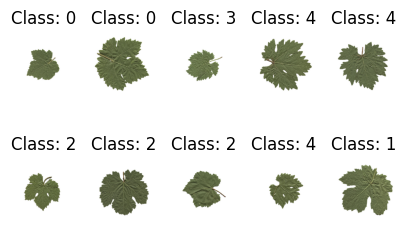

In [55]:
# Get a batch of images from the training set
sample_images, sample_labels = train_batch.next()

# Display a sample of images with their corresponding labels
plt.figure(figsize=(5, 3))
for i in range(10):  # Assuming batch_size is 10 in your training data generator
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"Class: {sample_labels[i].argmax()}")  # Assuming one-hot encoding for categorical classes
    plt.axis('off')
plt.show()

## Training VGG16

In [10]:
vgg = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False # we dont train the existing weights
print(vgg.summary())

58889256/58889256 [==============================] - 12s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                             

In [57]:
# Creating custom last layer

last_output = vgg.output
norm = BatchNormalization()(last_output)
x = Dropout(0.5)(norm)

flat = Flatten()(x) # Flattening the output from the previous layer
pred = Dense(5, activation='softmax', name='softmax')(flat) # we have 2 possibilites: Positive or Negative

new_model = Model(inputs=vgg.input, outputs=pred) # concatenates the layers
# top layers of the network
print(new_model.layers[-5:-1])

new_model.compile(Adam(lr=0.002), loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.perf_counter()
hist1 = new_model.fit(train_batch, 
                      steps_per_epoch = 20,
                      validation_data = val_batch, 
                      validation_steps=3, epochs=5, verbose=1)

time1 = round(time.perf_counter() - start_time, 2)
print (f'\n\nTime taken by VGG16: {time1} seconds')

[<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000022652C78520>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000022798822A00>, <keras.layers.regularization.dropout.Dropout object at 0x000002279CF07580>, <keras.layers.reshaping.flatten.Flatten object at 0x000002279CF07550>]
Epoch 1/5
20/20 [==============================] - 5s 189ms/step - loss: 3.5940 - accuracy: 0.4150 - val_loss: 1.5865 - val_accuracy: 0.4000
Epoch 2/5
20/20 [==============================] - 3s 142ms/step - loss: 1.3471 - accuracy: 0.7550 - val_loss: 1.0535 - val_accuracy: 0.5667
Epoch 3/5
20/20 [==============================] - 2s 124ms/step - loss: 0.6083 - accuracy: 0.8350 - val_loss: 0.7081 - val_accuracy: 0.7000
Epoch 4/5
20/20 [==============================] - 3s 134ms/step - loss: 0.7137 - accuracy: 0.8600 - val_loss: 0.8222 - val_accuracy: 0.7167
Epoch 5/5
20/20 [==============================] - 3s 138ms/step - loss: 0.4501 - accuracy: 0.9150 - val_loss:

## Mobile NetV2

In [20]:
mobileNet = MobileNetV2(input_shape=(224, 224, 3), 
                        weights='imagenet', include_top=False)
for layer in mobileNet.layers:
    layer.trainable = False
print(mobileNet.summary())

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [58]:
last_output = mobileNet.output
x = Flatten()(last_output)
custom_pred = Dense(5, activation='softmax', name='softmax')(x)
new_model = Model(inputs=mobileNet.input, outputs=custom_pred)

new_model.compile(Adam(lr=0.02), loss='categorical_crossentropy', 
                  metrics=['accuracy'])
start_time= time.perf_counter()
hist2 = new_model.fit(train_batch,
                      steps_per_epoch=20,
                      validation_data=val_batch, validation_steps=3,
                      epochs=5, verbose=1
                     )
time2 = round(time.perf_counter() - start_time, 2)
print(f'\n\nTime Taken by MobileNetV2: {time2} seconds')

Epoch 1/5
20/20 [==============================] - 6s 190ms/step - loss: 124.8263 - accuracy: 0.4250 - val_loss: 57.2094 - val_accuracy: 0.5833
Epoch 2/5
20/20 [==============================] - 2s 95ms/step - loss: 49.4425 - accuracy: 0.7750 - val_loss: 41.6524 - val_accuracy: 0.7167
Epoch 3/5
20/20 [==============================] - 2s 97ms/step - loss: 19.0966 - accuracy: 0.8700 - val_loss: 39.2140 - val_accuracy: 0.7333
Epoch 4/5
20/20 [==============================] - 2s 75ms/step - loss: 20.3673 - accuracy: 0.8200 - val_loss: 27.8700 - val_accuracy: 0.7833
Epoch 5/5
20/20 [==============================] - 2s 75ms/step - loss: 5.9794 - accuracy: 0.9500 - val_loss: 39.5200 - val_accuracy: 0.7833


Time Taken by MobileNetV2: 13.34 seconds


## Plotting the Comparison

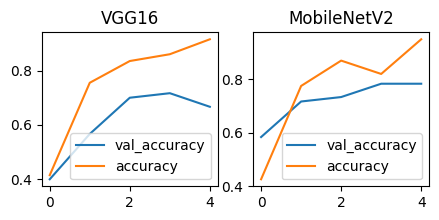

In [59]:
fig, ax = plt.subplots(1, 2, figsize=[5,2])
ax[0].plot(hist1.history['val_accuracy'], label='val_accuracy')
ax[0].plot(hist1.history['accuracy'], label='accuracy')
ax[0].set_title('VGG16')
ax[0].legend()

ax[1].plot(hist2.history['val_accuracy'], label='val_accuracy')
ax[1].plot(hist2.history['accuracy'], label='accuracy')
ax[1].set_title('MobileNetV2')
ax[1].legend()